In [ ]:
#| default_exp data.cv

# Image data

> Converting geospatial image and polygon data into object detection data formats

In [ ]:
#| hide

from nbdev.showdoc import *

In [ ]:
#| export

from geo2ml.data.coordinates import *
from pathlib import Path
import os
import yaml
import json
from fastcore.basics import *
from tqdm.auto import tqdm
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from shapely.geometry import box
import datetime
from skimage import measure
from pycocotools.mask import frPyObjects
from shapely.geometry import MultiPolygon, Polygon
import math

In [ ]:
from geo2ml.plotting import *
from matplotlib import pyplot as plt

## COCO conversions

Annotations in COCO style datasets are stored in a single json-file, which looks like this:

```json
{
    "info": { 
        "year": "<year_of_creation>",
        "version": "<dataset_version>",
        "description": "<description>",
        "contributor": "<author>",
        "url":" <url>",
        "date_created": "<creation_date>"
    },
    "licenses": [
        {
            "url": "<url_to_license>",
            "id": <license_id_number>,
            "name" <"license_name>"
        },
        ...
    ],
    "images": [
        {
            "id": 0,
            "license": "<license_id>",
            "file_name": "<filename.ext>",
            "height": "<height_in_px>",
            "width": "<width_in_px>",
            "date_captured": null
        },
        ...
    ],
    "annotations": [
        {
            "id": <annotation_id>,
            "image_id": <corresponding_image_id>,
            "category_id": <corresponding_cat_id>,
            "bbox": [xmin, ymin, xdelta, ydelta],
            "segmentation": [x0, y0, x1, y1, ...],
            "area": <area_in_pixels>,
            "is_crowd": <1 or 0>
        },
        ...
    ],
    "categories": [
        {
            "id": <cat_id>,
            "name": "<cat_name>",
            "supercategory": "<supercat_name>"
        }
    ]
}

```

Of these, `images`, `annotations` and `categories` are mandatory.

In [ ]:
#| exporti

def calc_bearing(point1, point2):
    "Get the angle of the rotated bounding box in radians"
    x1, y1 = point1
    x2, y2 = point2
    theta = math.atan2(y2 - y1, x2 - x1)
    theta = nor_theta(theta)
    return theta

def nor_theta(theta):
    "Convert angle to simpler format"
    if theta > math.radians(45):
        theta -= math.radians(90)
        theta = nor_theta(theta)
    elif theta <= math.radians(-45):
        theta += math.radians(90)
        theta = nor_theta(theta)
    return theta

def _corners2rotatedbbox(poly):
    """Return rotated bounding box in (xc, yc, w, h, a) format used by detectron2 
    (xc, yc) is the center of the rotated box, a is the angle in degrees ccw"""
    centre = poly.centroid.coords.xy
    corners = np.array(poly.exterior.coords)
    theta = calc_bearing(corners[0], corners[1])
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta), np.cos(theta)]])
    out_points = np.matmul(corners - np.array(centre).T, rotation) + np.array(centre).T
    x, y = list(out_points[0,:])
    w, h = list(out_points[2, :] - out_points[0, :])
    return [centre[0][0], centre[1][0], np.abs(w), np.abs(h), -(theta*180)/np.pi] # Convert angle from radians to ccw degrees

In [ ]:
#| exporti

def _process_shp_to_coco(image_id, category_id, ann_id, poly:Polygon, rotated_bbox:bool=False):
    "TODO handle multipolygons better"
    ann_dict = {
        'segmentation': [],
        'area': None, 
        'bbox': [],
        'category_id': category_id,
        'id' : ann_id,
        'image_id': image_id,
        'iscrowd': 0,
    }

    if poly.geom_type == 'Polygon':
        ann_dict['segmentation'] = [list(sum(poly.exterior.coords[:-1], ()))]
        if not rotated_bbox:
            ann_dict['bbox'] = [(poly.bounds[0]), 
                                (poly.bounds[1]), 
                                (poly.bounds[2]-poly.bounds[0]), 
                                (poly.bounds[3]-poly.bounds[1])]
        else: # XYWHA is the requirement for rotated bounding boxes
            ann_dict['bbox'] = _corners2rotatedbbox(poly.minimum_rotated_rectangle)
        ann_dict['area'] = poly.area
    elif poly.geom_type == 'MultiPolygon':
        temp_poly = None
        max_area = 0
        # Take only the largest polygon
        for p in poly.geoms:
            area = p.area
            if area > max_area:
                max_area = area
                temp_poly = p
        ann_dict['segmentation'] = [list(sum(temp_poly.exterior.coords[:-1], ()))]
        if not rotated_bbox:
            ann_dict['bbox'] = [(temp_poly.bounds[0]), 
                                (temp_poly.bounds[1]), 
                                (temp_poly.bounds[2]-temp_poly.bounds[0]), 
                                (temp_poly.bounds[3]-temp_poly.bounds[1])]
        else:
            ann_dict['bbox'] = _corners2rotatedbbox(temp_poly.minimum_rotated_rectangle.exterior.coords)
        ann_dict['area'] = temp_poly.area
    return ann_dict

In [ ]:
#| export

def shp_to_coco(raster_path:Path, shp_path:Path, outpath:Path, label_col:str, 
                coco_categories:dict, coco_info:dict=None, coco_licenses:dict=None,
                min_bbox_area:int=0, rotated_bbox:bool=False, dataset_name:str=None):
    "Create a COCO style dataset from images in `raster_path` and corresponding polygons in `shp_path`, save annotations to `outpath`"

    coco_dict = {
        'images': [],
        'annotations': [],
        'categories': coco_categories
    }
    if coco_info: coco_dict['info'] = coco_info
    if coco_licenses: coco_dict['licenses'] = coco_licenses
    categories = {c['name']:c['id'] for c in coco_dict['categories']}

    vector_tiles = [f for f in os.listdir(shp_path) if f.endswith(('.shp', '.geojson'))]
    raster_tiles = [f for f in os.listdir(raster_path) if f.split('.')[0] in [v.split('.')[0] for v in vector_tiles]]
    ann_id = 1
    for i, r in tqdm(enumerate(raster_tiles)):
        tile_anns = []
        gdf = gpd.read_file(shp_path/vector_tiles[i])
        tfmd_gdf = gdf_to_px(gdf, raster_path/r, precision=3)
        for row in tfmd_gdf.itertuples():
            category_id = categories[getattr(row, label_col)]
            if box(*row.geometry.bounds).area < min_bbox_area: continue # if bounding box is smaller than `min_bbox_area` pixels then exclude it
            tile_anns.append(_process_shp_to_coco(i, category_id, ann_id, row.geometry, rotated_bbox))
            ann_id += 1
        if len(tile_anns) > 0:
            with rio.open(raster_path/r) as im: 
                h, w = im.shape
            coco_dict['images'].append({'file_name': r,'id': i, 'height':h, 'width':w})
            coco_dict['annotations'].extend(tile_anns)

    outfile = f'{dataset_name}.json' if dataset_name else 'coco.json'
    with open(outpath/outfile, 'w') as f: json.dump(coco_dict, f)
    return

Create an example dataset.

In [ ]:
deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'Fallen'},
        {'supercategory':'deadwood', 'id':2, 'name': 'Standing'},
    ]

coco_info = {'description': 'dummydataset for example purposes',
             'version': 0.1,
             'year': 2023,
             'contributor': 'Janne Mäyrä',
             'date_created': datetime.date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

Convert the dataset to COCO format.

In [ ]:
outpath = Path('example_data/tiles/')

shp_to_coco(raster_path=outpath/'images', shp_path=outpath/'vectors', outpath=outpath, label_col='label',
            dataset_name='coco_norm', coco_info=coco_info, coco_categories=deadwood_categories)

0it [00:00, ?it/s]

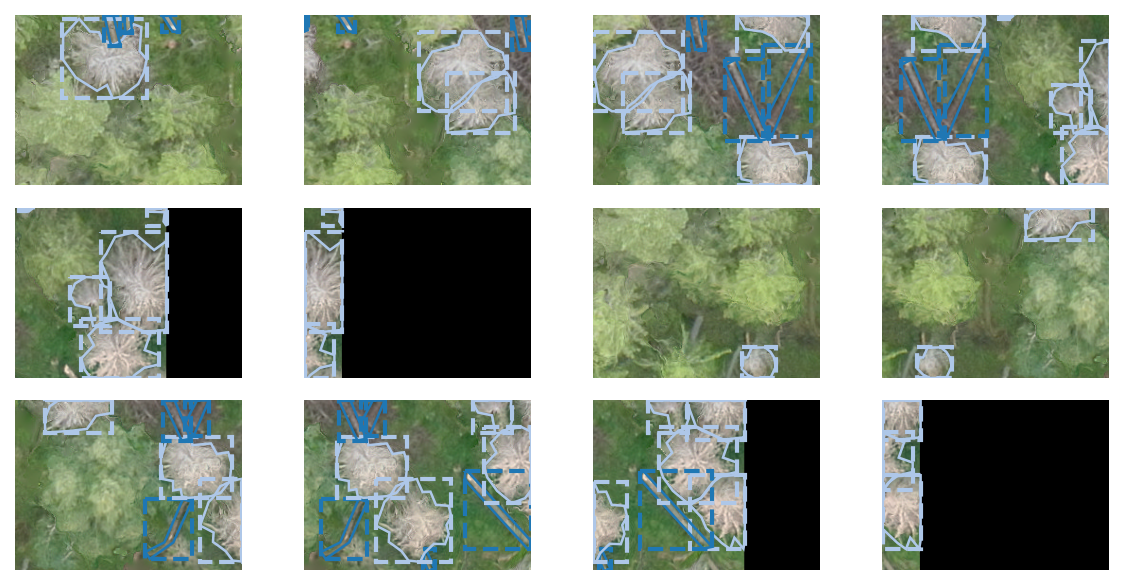

In [ ]:
data_path = Path('example_data/tiles/')

with open(data_path/'coco_norm.json') as f:
    coco_data = json.load(f)

fig, axs = plt.subplots(3,4, figsize=(8,4), dpi=150)
for i, ax in enumerate(axs.flatten()):
    plot_coco_instance(coco_data, i, data_path/'images', ax, show_labels=False, show_title=False)
plt.tight_layout()
plt.show()

It is also possible to save the dataset with rotated bounding boxes:

In [ ]:
shp_to_coco(raster_path=outpath/'images', shp_path=outpath/'vectors', outpath=outpath, label_col='label',
            dataset_name='coco_rot', coco_info=coco_info, coco_categories=deadwood_categories, rotated_bbox=True)

0it [00:00, ?it/s]

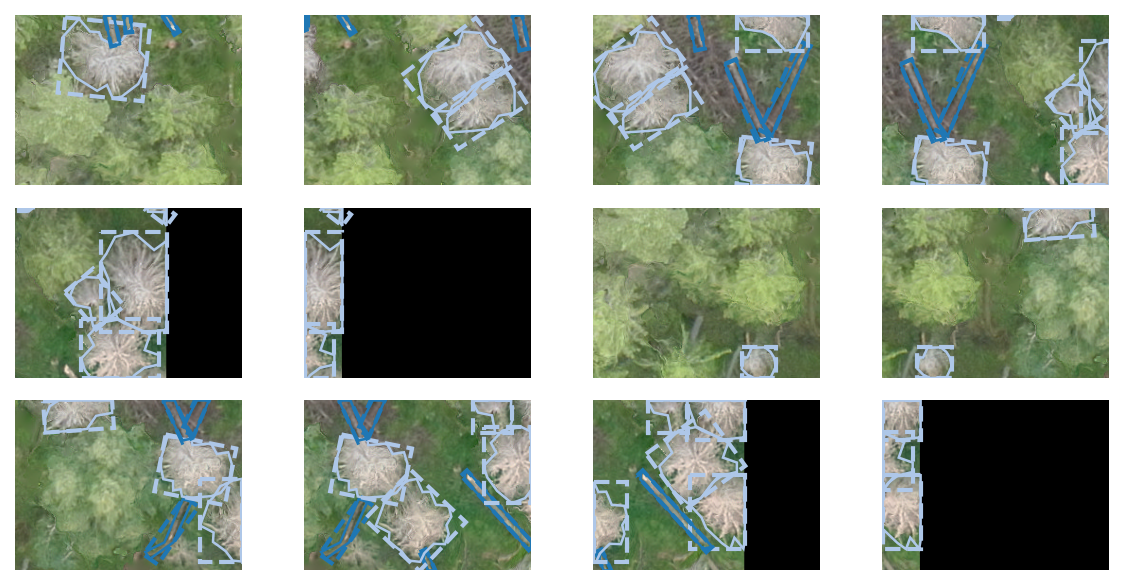

In [ ]:
with open(data_path/'coco_rot.json') as f:
    coco_rot_data = json.load(f)

fig, axs = plt.subplots(3,4, figsize=(8,4), dpi=150)
for i, ax in enumerate(axs.flatten()):
    plot_coco_instance(coco_rot_data, i, data_path/'images', ax, show_labels=False, show_title=False)
plt.tight_layout()
plt.show()

In [ ]:
#| export

def coco_to_shp(coco_data:Path|str, outpath:Path, raster_path:Path,
                downsample_factor:int=1):
    """Generates georeferenced data from a dictionary with coco annotations.
    TODO handle multipolygons better"""
    
    if not os.path.exists(outpath): os.makedirs(outpath)

    with open(coco_data) as f:
        coco_dict = json.load(f)
    
    annotations = coco_dict['annotations']
    images = coco_dict['images']
    categories = coco_dict['categories']
    for i in tqdm(images):
        anns_in_image = [a for a in annotations if a['image_id'] == i['id']]
        if len(anns_in_image) == 0: continue
        cats = []
        polys = []
        scores = []
        cat_names = []
        for a in anns_in_image:
            # No segmentations, only bounding boxes
            if a['segmentation'] is None:
                cats.append(a['category_id'])
                cat_names.append([c['name'] for c in categories if c['id'] == a['category_id']][0])
                if len(a['bbox']) == 4:
                    # Bbox has format xmin, ymin, xdelta, ydelta
                    polys.append(box(a['bbox'][0] / downsample_factor, 
                                     a['bbox'][1] / downsample_factor, 
                                     (a['bbox'][2] + a['bbox'][0]) / downsample_factor, 
                                     (a['bbox'][3]+a['bbox'][1]) / downsample_factor))
                elif len(a['bbox']) == 5:
                    # Rotated bbox has format x_center, y_center, w, h, angle
                    xc = a['bbox'][0]
                    yc = a['bbox'][1]
                    w = a['bbox'][2]
                    h = a['bbox'][3]
                    angle = -np.radians(a['bbox'][4])
                    ax = xc + ((w/2)*np.cos(angle)) - ((h/2)*np.sin(angle))
                    ay = yc + ((w/2)*np.sin(angle)) + ((h/2)*np.cos(angle))

                    bx = xc - ((w/2)*np.cos(angle)) - ((h/2)*np.sin(angle))
                    by = yc - ((w/2)*np.sin(angle)) + ((h/2)*np.cos(angle))

                    cx = xc - ((w/2)*np.cos(angle)) + ((h/2)*np.sin(angle))
                    cy = yc - ((w/2)*np.sin(angle)) - ((h/2)*np.cos(angle))

                    dx = xc + ((w/2)*np.cos(angle)) + ((h/2)*np.sin(angle))
                    dy = yc + ((w/2)*np.sin(angle)) - ((h/2)*np.cos(angle))
                    polys.append(Polygon([(ax,ay), (bx,by), (cx,cy), (dx,dy)]))
                if 'score' in a.keys():
                    scores.append(a['score'])
            # Single polygon
            elif len(a['segmentation']) == 1:
                cats.append(a['category_id'])
                cat_names.append([c['name'] for c in categories if c['id'] == a['category_id']][0])
                xy_coords = [(a['segmentation'][0][i]  / downsample_factor, 
                              a['segmentation'][0][i+1] / downsample_factor) 
                             for i in range(0,len(a['segmentation'][0]),2)]
                xy_coords.append(xy_coords[-1])
                polys.append(Polygon(xy_coords))
                if 'score' in a.keys():
                    scores.append(a['score'])
            # Multipolygon 
            else: 
                temp_poly = None
                max_area = 0
                cats.append(a['category_id'])
                cat_names.append([c['name'] for c in categories if c['id'] == a['category_id']][0])
                for p in range_of(a['segmentation']):
                    xy_coords = [(a['segmentation'][p][i] / downsample_factor, 
                                  a['segmentation'][p][i+1] / downsample_factor) 
                                 for i in range(0,len(a['segmentation'][p]),2)]
                    xy_coords.append(xy_coords[-1])
                    if Polygon(xy_coords).area > max_area:
                        temp_poly = Polygon(xy_coords)
                        max_area = temp_poly.area
                polys.append(temp_poly)
                if 'score' in a.keys():
                    scores.append(a['score'])
        gdf = gpd.GeoDataFrame({'label_id':cats, 'label': cat_names, 'geometry':polys})
        if len(scores) != 0: gdf['score'] = scores
        tfmd_gdf = georegister_px_df(gdf, raster_path/i["file_name"])
        tfmd_gdf.to_file(outpath/f'{i["file_name"][:-4]}.geojson', driver='GeoJSON')
    return

In [ ]:
coco_to_shp(outpath/'coco_norm.json', outpath/'predicted_vectors_coco', outpath/'images')

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Converted annotations')

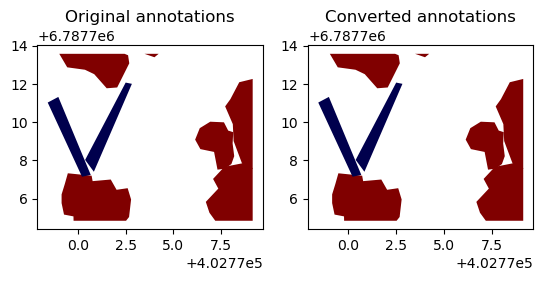

In [ ]:
fig, axs = plt.subplots(1,2, dpi=100)
orig_annos = gpd.read_file(outpath/'vectors/R0C3.geojson')
orig_annos.plot(ax=axs[0], column='label', cmap='seismic').set_title('Original annotations')
converted_annos = gpd.read_file(outpath/'predicted_vectors_coco/R0C3.geojson')
converted_annos.plot(ax=axs[1], column='label', cmap='seismic').set_title('Converted annotations')

In [ ]:
#| export

def shp_to_coco_results(prediction_path:Path, raster_path:Path, coco_dict:Path, outpath:Path):
    "Convert vector predictions into coco result format to be fed into COCO evaluator"

    with open(coco_dict) as f:
        coco_dict = json.load(f)
    
    vector_tiles = [f for f in os.listdir(prediction_path) if f.endswith(('.shp', '.geojson'))]
    raster_tiles = [f for f in os.listdir(raster_path) if f.split('.')[0] in [v.split('.')[0] for v in vector_tiles]]
    results = []
    for i in tqdm(range_of(raster_tiles)):
        for im_id, im in enumerate(coco_dict['images']):
            if im['file_name'] == raster_tiles[i]:
                break
        image_id = coco_dict['images'][im_id]['id']
        h = coco_dict['images'][im_id]['height']
        w = coco_dict['images'][im_id]['width']
        gdf = gpd.read_file(f'{self.prediction_path}/{result_tiles[i]}')
        tfmd_gdf = gdf_to_px(gdf, raster_path/raster_tiles[i], precision=3)
        for row in tfmd_gdf.itertuples():
            res = {'image_id': image_id,
                   'category_id': getattr(row, label_col),
                   'segmentation': None,
                   'score': np.round(getattr(row, 'score'), 5)}
            ann = _process_shp_to_coco(image_id, getattr(row, label_col), 0, row.geometry, rotated_bbox)
            res['segmentation'] = frPyObjects(ann['segmentation'], h, w)[0]
            res['segmentation']['counts'] = res['segmentation']['counts'].decode('ascii')
            results.append(res)
    
    with open(outpath, 'w') as f: 
        json.dump(results, f)
    return

## YOLO

Specifications of yolo format:

* The folder structure must be so that images are in a folder called `images` and annotations in a folder `labels`
* Each image must have a corresponding annotation file with a same name aside from file type (`txt`)
* Each `txt` contains all annotations in separate rows
  * Bounding box annotation format is `classid` `x_center` `y_center` `width` `height`
  * Polygon annotation format `classid` `x` `y` `x` `y`...
* Coordinates are normalized between 0 and 1, so that origin is at upper left and (1,1) in bottom right
* Train/val/test -sets are collated in separate files, with the paths to image files
* Information is collated on a `yaml` file, where
  * `path: <path>` is the dataset root dir
  * `train: `, `val: ` and `test: ` are either:
    1. directories
    2. txt-files containing images
    3. list containing paths
  * class names are saved like
  ```yaml
  names: 
      0: person
      1: bicycle
  ```

In [ ]:
#| export

def shp_to_yolo(raster_path:Path, shp_path:Path, outpath:Path, label_col:str, names:list,
                ann_format:str='box', min_bbox_area:int=0, dataset_name:str=None):
    "Convert shapefiles in `shp_path` to YOLO style dataset. Creates a folder `labels` and `dataset_name.yaml`  to `outpath`"
    vector_tiles = [f for f in os.listdir(shp_path) if f.endswith(('.shp', '.geojson'))]
    raster_tiles = [f for f in os.listdir(raster_path) if f.split('.')[0] in [v.split('.')[0] for v in vector_tiles]]
    ann_path = outpath/'labels'
    os.makedirs(ann_path, exist_ok=True)
    names = {n: i for i, n in enumerate(names)}
    for i, r in tqdm(enumerate(raster_tiles)):
        gdf = gpd.read_file(shp_path/vector_tiles[i])
        if ann_format == 'rotated box':
            gdf['geometry'] = gdf.geometry.apply(lambda row: row.minimum_rotated_rectangle)
        tfmd_gdf = gdf_to_px(gdf, raster_path/r, precision=3) # to pixel coordinates
        with rio.open(raster_path/r) as im:
            h, w = im.shape
        anns = []
        for row in tfmd_gdf.itertuples():
            cat_id = names[getattr(row, label_col)]
            if box(*row.geometry.bounds).area < min_bbox_area: continue
            if ann_format == 'box': #classid x_c y_c w h
                x_c = row.geometry.centroid.x / w
                y_c = row.geometry.centroid.y / h
                b_w = (row.geometry.bounds[2]-row.geometry.bounds[0])/w
                b_h = (row.geometry.bounds[3]-row.geometry.bounds[1])/h
                anns.append(f'{cat_id} {x_c} {y_c} {b_w} {b_h}')
                
            else: #classid x y x y ...
                coords = ' '.join(list(sum([(str(x/w), str(y/h))for x, y in row.geometry.exterior.coords[:-1]], ())))
                anns.append(str(cat_id) + ' ' + coords)
                
            with open(ann_path/f'{r.split(".")[0]}.txt', 'w') as dest:
                for ann in anns: dest.write(f'{ann}\n')             
    outfile = f'{dataset_name}.yaml' if dataset_name else 'yolo.yaml'
    with open(outpath/outfile, 'w') as dest:
        # Todo handle specifying train/val/test .-sets
        dest.write('# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3: list: [path/to_imgs1, path_to_imgs2, ..]\n')
        dest.write(f'path: {outpath} # dataset root dir \n')
        dest.write(f"train: # train images (relative to 'path')\n")
        dest.write(f"val: # val images (relative to 'path')\n")
        dest.write(f"test: # test images (relative to 'path')\n")
        dest.write('\n# Classes\n')
        dest.write('names:\n')
        for n in names.keys():
            dest.write(f'  {names[n]}: {n}\n')

In [ ]:
cats = ['Standing', 'Fallen']
shp_to_yolo(outpath/'images', outpath/'vectors', outpath, label_col='label', 
            names=cats, dataset_name='yolo_box')

0it [00:00, ?it/s]

In [ ]:
with open('example_data/tiles/labels/R0C3.txt') as f:
    print(f.read())

0 0.9110088813754431 0.8428313957277873 0.2105125 0.34474444444444446
0 0.8408608699710605 0.5332844921858052 0.1755499999999999 0.28715555555555555
0 0.9556222313151289 0.4008342356126551 0.12364166666666669 0.5387388888888888
0 0.2896889458001481 0.8741472392259093 0.3121958333333333 0.28441666666666665
1 0.17423794402298073 0.49100616152477305 0.19327083333333334 0.47804444444444444
1 0.3449062720847152 0.45305794267666205 0.21007916666666665 0.5340611111111111
0 0.31508289921660215 0.07376972745127364 0.3144166666666666 0.20641666666666666
0 0.5501041666666667 0.006870370370370371 0.06359166666666667 0.02061111111111111



<Axes: >

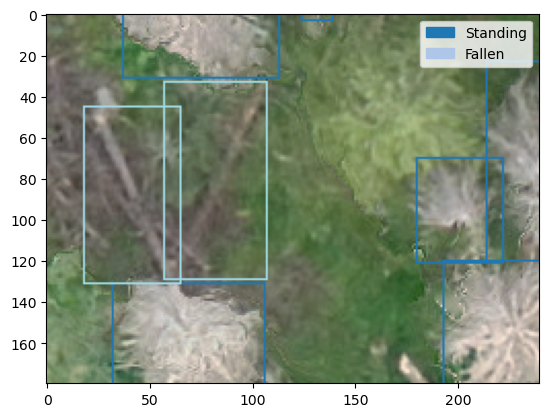

In [ ]:
fig, ax = plt.subplots(1,1)
plot_yolo_instance(Path('example_data/tiles/labels/R0C3.txt'), 
                   Path('example_data/tiles/images/R0C3.tif'), 
                   ax, ann_type='box',
                   classes=cats)

In [ ]:
shp_to_yolo(outpath/'images', outpath/'vectors', outpath, label_col='label', 
            ann_format='polygon', names=cats, dataset_name='yolo_poly')

0it [00:00, ?it/s]

<Axes: >

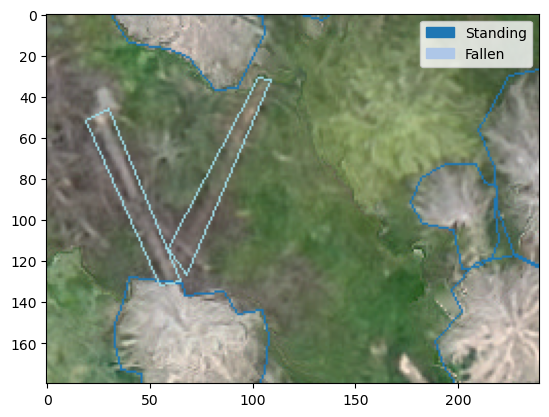

In [ ]:
fig, ax = plt.subplots(1,1)
plot_yolo_instance(Path('example_data/tiles/labels/R0C3.txt'), 
                   Path('example_data/tiles/images/R0C3.tif'), 
                   ax, ann_type='polygon',
                   classes=cats)

In [ ]:
#| export

def yolo_to_shp(prediction_path:Path, raster_path:Path, yolo_path:Path|str, outpath:Path,
                downsample_factor:int=1, ann_format:str='polygon'):
    """Convert predicted files in `predictions` to georeferenced data based on files in `images`.
    ann_format is one of `polygon`, `xyxy`, `xywh`, `xyxyn`, `xywhn`.
    """
    
    if ann_format not in ['polygon', 'xyxy', 'xywh', 'xyxyn', 'xywhn']:
        print(f'ann_format must be one of polygon, xyxy, xywh, xyxyn, xywhn, was {ann_format}')
        return
    if not os.path.exists(outpath): os.makedirs(outpath, exist_ok=True)
        
    pred_files = os.listdir(prediction_path)
    raster_tiles = [f for f in os.listdir(raster_path) if f.split('.')[0] in [v.split('.')[0] for v in pred_files]]
    yolo_dict = yaml.safe_load(Path(yolo_path).read_text())
    names = yolo_dict['names']
    
    for p in tqdm(pred_files):
        with open(prediction_path/p, 'r') as f:
            preds = [line.rstrip() for line in f]
        matching_image = [i for i in raster_tiles if p.split('.')[0] in i][0]
        with rio.open(raster_path/matching_image) as im:
            h, w = im.shape
        label_ids = []
        labels = []
        polys = []
        scores = []
        if ann_format == 'polygon':
            for pred in preds: # label x y x y x y ... x y conf
                if len(pred) == 0: continue
                pred = pred.split(' ')
                label_ids.append(int(pred[0]))
                labels.append(names[int(pred[0])])
                score = scores.append(float(pred[-1]))
                xs = [float(pred[i])*w for i in range(1, len(pred), 2)]
                ys = [float(pred[i])*h for i in range(2, len(pred), 2)]
                xy_coords = list(zip(xs, ys))
                xy_coords.append(xy_coords[-1])
                polys.append(Polygon(xy_coords))    
        elif ann_format in ['xyxy', 'xyxyn']: # label x1 y1 x2 y2 conf
            for pred in preds:
                if len(pred) == 0: continue
                label_id, x1, y1, x2, y2, score = pred.split(' ')
                label_ids.append(int(label_id))
                labels.append(names[int(label_id)])
                scores.append(float(score))
                x1 = float(x1) * w if ann_format == 'xyxyn' else float(x1)
                y1 = float(y1) * h if ann_format == 'xyxyn' else float(y1)
                x2 = float(x2) * w if ann_format == 'xyxyn' else float(x2)
                y2 = float(y2) * h if ann_format == 'xyxyn' else float(y2)
                polys.append(box(x1, y1, x2, y2))
        elif ann_format in ['xywh', 'xywhn']: # label xc yc bw bh conf:
            for pred in preds:
                if len(pred) == 0: continue
                label_id, xc, yc, bw, bh, score = pred.split(' ')
                label_ids.append(int(label_id))
                labels.append(names[int(label_id)])
                scores.append(float(score))
                xc = float(xc) * w if ann_format == 'xywhn' else float(xc)
                yc = float(yc) * h if ann_format == 'xywhn' else float(yc)
                bw = float(bw) * w if ann_format == 'xywhn' else float(bw)
                bh = float(bh) * h if ann_format == 'xywhn' else float(bh)
                polys.append(box(xc - (bw/2), yc - (bh/2), xc+(bw/2), y2+(bh/2)))
        
        gdf = gpd.GeoDataFrame({'label': labels, 'label_id': label_ids, 'geometry': polys, 'score': scores})
        tfmd_gdf = georegister_px_df(gdf, raster_path/matching_image)
        tfmd_gdf.to_file(outpath/p.replace("txt", "geojson"), driver='GeoJSON')
    return

In [ ]:
yolo_to_shp(outpath/'labels', outpath/'images', outpath/'yolo_poly.yaml', outpath/'predicted_vectors_yolo')

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Converted annotations')

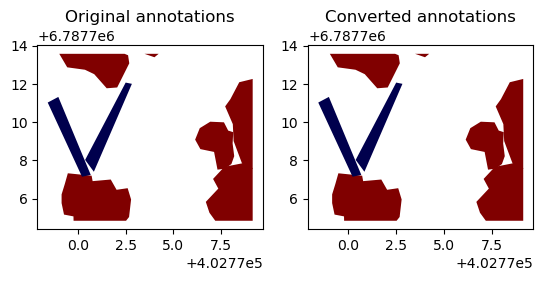

In [ ]:
fig, axs = plt.subplots(1,2, dpi=100)
orig_annos = gpd.read_file(outpath/'vectors/R0C3.geojson')
orig_annos.plot(ax=axs[0], column='label', cmap='seismic').set_title('Original annotations')
converted_annos = gpd.read_file(outpath/'predicted_vectors_yolo/R0C3.geojson')
converted_annos.plot(ax=axs[1], column='label', cmap='seismic').set_title('Converted annotations')